In [7]:
import xgboost as xgb
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing, pipeline, metrics, grid_search, cross_validation
import time
import random
import numpy as np
import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.externals import joblib
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import requests, json

## Define functions

In [8]:
# load train and test data and output full data and column dictionary
def load_data():
    # Load data
    start = time.time() 
    train = pd.read_csv('./data/train.csv', parse_dates=['DateTime'])
    print ("Loading train data finished in %0.3fs" % (time.time() - start))        

    test = pd.read_csv('./data/test.csv', parse_dates=['DateTime'])
    print ("Loading test data finished in %0.3fs" % (time.time() - start))  

    # seperate column names by categorical, numerical, label, and id
    data_types = train.dtypes  
    categorical_cols = list(data_types[data_types=='object'].index) + list(data_types[data_types=='datetime64[ns]'].index)
    numerical_cols = list(data_types[data_types=='int64'].index) + list(data_types[data_types=='float64'].index)

    dict_cols = dict()
    # categorical columns
    dict_cols['categorical_cols'] = categorical_cols
    dict_cols['categorical_cols'].remove('AnimalID') # remove ids
    dict_cols['categorical_cols'].remove('OutcomeType') # remove labels
    dict_cols['categorical_cols'].remove('OutcomeSubtype')

    # numeric columns
    dict_cols['numerical_cols'] = numerical_cols

    # id columns
    dict_cols['id_col'] = ['AnimalID']

    # label columns
    dict_cols['label_col'] = ['OutcomeType']
    
    # Merge train and test
    dict_cols['train_size'] = train.shape[0]
    dict_cols['test_size'] = test.shape[0]
    print 'train data size: %s' % dict_cols['train_size']
    print 'test data size: %s' % dict_cols['test_size']

    full_data = pd.concat([train[dict_cols['categorical_cols'] + dict_cols['numerical_cols'] + dict_cols['label_col']]
                         , test[dict_cols['categorical_cols'] + dict_cols['numerical_cols']]
                        ])
    
    return dict_cols, full_data

In [9]:
## function to grid search the best model
def search_model(train_x, train_y, est, param_grid, n_jobs, cv, refit=False):
    model = grid_search.GridSearchCV(estimator  = est, 
                                     param_grid = param_grid, 
                                     scoring = 'log_loss', 
                                     verbose = 10, 
                                     n_jobs  = n_jobs, 
                                     iid = True, # is identically distributed 
                                     refit = refit,
                                     cv = cv)
    # Fit Grid Search Model
    model.fit(train_x, train_y)
    print("Best score: %0.3f" % model.best_score_)
    print("Best parameters set:", model.best_params_)
    print("Scores:", model.grid_scores_)
    return model

In [10]:
# function to plot feature importance
def plot_feature_importance(feature_importances, feature_names):
    ftr_imp_df = pd.DataFrame(sorted(zip(feature_names, feature_importances)
                          , key=lambda x: x[1], reverse = False)
                   )
    y_pos = np.arange(ftr_imp_df.shape[0])

    plt.barh(y_pos, ftr_imp_df[1], align='center', alpha=0.4)
    plt.yticks(y_pos, ftr_imp_df[0])
    plt.xlabel('Feature Importance')

    plt.show()

In [11]:
# function to label encoding, and output label mapping
def label_encoding(cols, full_data):
    label_mapping = {}
    for col in cols:
        print("Label encoding column: %s" % (col))
        LBL = preprocessing.LabelEncoder()
        LBL.fit(full_data[col])
        if col == 'OutcomeType':
            label_mapping = dict(zip(full_data['OutcomeType'].unique(), LBL.transform(full_data['OutcomeType'].unique())))
#             print("Label mapping: %s" % (label_mapping))
        full_data[col] = LBL.transform(full_data[col])
        
    return label_mapping

## Benchmark

In [659]:
dict_cols, full_data = load_data()

Loading train data finished in 0.076s
Loading test data finished in 0.099s
train data size: 26729
test data size: 11456


In [660]:
label_encoding(dict_cols['categorical_cols'] + dict_cols['label_col'], full_data)

Label encoding column: Name
Label encoding column: AnimalType
Label encoding column: SexuponOutcome
Label encoding column: AgeuponOutcome
Label encoding column: Breed
Label encoding column: Color
Label encoding column: DateTime
Label encoding column: OutcomeType


{nan: 0,
 'Adoption': 1,
 'Died': 2,
 'Euthanasia': 3,
 'Return_to_owner': 4,
 'Transfer': 5}

In [475]:
train_X = full_data[:dict_cols['train_size']][dict_cols['categorical_cols'] + dict_cols['numerical_cols']].values
train_y = full_data[:dict_cols['train_size']][dict_cols['label_col']].values.reshape(dict_cols['train_size'])
param_grid = {'criterion':['gini', 'entropy'], 'n_estimators':[500], 'random_state' : [1234]}

In [476]:
model = search_model(train_X
            , train_y
            , RandomForestClassifier()
            , param_grid
            , -1
            , 4
            , True)

Fitting 4 folds for each of 2 candidates, totalling 8 fits
[CV] n_estimators=500, random_state=1234, criterion=gini .............
[CV] n_estimators=500, random_state=1234, criterion=gini .............
[CV] n_estimators=500, random_state=1234, criterion=gini .............
[CV] n_estimators=500, random_state=1234, criterion=gini .............
[CV] n_estimators=500, random_state=1234, criterion=entropy ..........
[CV] n_estimators=500, random_state=1234, criterion=entropy ..........
[CV] n_estimators=500, random_state=1234, criterion=entropy ..........
[CV] n_estimators=500, random_state=1234, criterion=entropy ..........
[CV]  n_estimators=500, random_state=1234, criterion=gini, score=-0.950719 -  24.5s
[CV]  n_estimators=500, random_state=1234, criterion=gini, score=-1.006661 -  24.6s
[CV]  n_estimators=500, random_state=1234, criterion=gini, score=-0.982154 -  24.7s


[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   24.6s remaining:   -2.7s
[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   24.8s remaining:   -2.8s


[CV]  n_estimators=500, random_state=1234, criterion=gini, score=-0.969933 -  24.8s


[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   24.8s remaining:   -2.8s


[CV]  n_estimators=500, random_state=1234, criterion=entropy, score=-1.014275 -  35.2s
[CV]  n_estimators=500, random_state=1234, criterion=entropy, score=-0.969241 -  35.2s


[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   35.3s remaining:   -3.9s
[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   35.3s remaining:   -3.9s


[CV]  n_estimators=500, random_state=1234, criterion=entropy, score=-0.983725 -  35.4s
[CV]  n_estimators=500, random_state=1234, criterion=entropy, score=-0.972565 -  35.5s


[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   35.5s remaining:   -3.9s
[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   35.6s remaining:   -4.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   35.6s finished


Best score: -0.977
('Best parameters set:', {'n_estimators': 500, 'random_state': 1234, 'criterion': 'gini'})
('Scores:', [mean: -0.97737, std: 0.02029, params: {'n_estimators': 500, 'random_state': 1234, 'criterion': 'gini'}, mean: -0.98496, std: 0.01776, params: {'n_estimators': 500, 'random_state': 1234, 'criterion': 'entropy'}])


In [ ]:
# plot feature importance
plot_feature_importance(model.best_estimator_.feature_importances_, dict_cols['categorical_cols'] + dict_cols['numerical_cols'])

## Transform age into days

In [14]:
# function to transform ages into days
def age2days(age):
    age = str(age)
    if 'day' in age:
        days = int(age.split(' ')[0])
    if 'week' in age:
        days= int(age.split(' ')[0])*7
    if 'month' in age:
        days = int(age.split(' ')[0])*30
    if 'year' in age:
        days = int(age.split(' ')[0])*365    
    else:
        days = 0
    return days   

In [15]:
dict_cols, full_data = load_data()

Loading train data finished in 0.065s
Loading test data finished in 0.087s
train data size: 26729
test data size: 11456


In [16]:
full_data['AgeuponOutcome'] = full_data['AgeuponOutcome'].apply(age2days)

In [17]:
dict_cols['categorical_cols'].remove('AgeuponOutcome')
dict_cols['numerical_cols'].append('AgeuponOutcome')

In [18]:
label_encoding(dict_cols['categorical_cols'] + dict_cols['label_col'], full_data)

Label encoding column: Name
Label encoding column: AnimalType
Label encoding column: SexuponOutcome
Label encoding column: Breed
Label encoding column: Color
Label encoding column: DateTime
Label encoding column: OutcomeType


{nan: 0,
 'Adoption': 1,
 'Died': 2,
 'Euthanasia': 3,
 'Return_to_owner': 4,
 'Transfer': 5}

In [19]:
train_X = full_data[:dict_cols['train_size']][dict_cols['categorical_cols'] + dict_cols['numerical_cols']].values
train_y = full_data[:dict_cols['train_size']][dict_cols['label_col']].values.reshape(dict_cols['train_size'])
param_grid = {'criterion':['gini', 'entropy'], 'n_estimators':[500], 'random_state' : [1234]}
model = search_model(train_X
            , train_y
            , RandomForestClassifier()
            , param_grid
            , -1
            , 4
            , True)

Fitting 4 folds for each of 2 candidates, totalling 8 fits
[CV] n_estimators=500, random_state=1234, criterion=gini .............
[CV] n_estimators=500, random_state=1234, criterion=gini .............
[CV] n_estimators=500, random_state=1234, criterion=gini .............
[CV] n_estimators=500, random_state=1234, criterion=gini .............
[CV] n_estimators=500, random_state=1234, criterion=entropy ..........
[CV] n_estimators=500, random_state=1234, criterion=entropy ..........
[CV] n_estimators=500, random_state=1234, criterion=entropy ..........
[CV] n_estimators=500, random_state=1234, criterion=entropy ..........
[CV]  n_estimators=500, random_state=1234, criterion=gini, score=-1.018751 -  22.7s
[CV]  n_estimators=500, random_state=1234, criterion=gini, score=-1.020380 -  22.8s
[CV]  n_estimators=500, random_state=1234, criterion=gini, score=-0.995470 -  22.9s
[CV]  n_estimators=500, random_state=1234, criterion=gini, score=-1.009852 -  22.9s


[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   22.8s remaining:   -2.5s
[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   22.9s remaining:   -2.5s
[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   23.0s remaining:   -2.6s


[CV]  n_estimators=500, random_state=1234, criterion=entropy, score=-1.052441 -  31.8s
[CV]  n_estimators=500, random_state=1234, criterion=entropy, score=-0.999346 -  31.9s


[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   31.9s remaining:   -3.5s
[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   32.0s remaining:   -3.6s


[CV]  n_estimators=500, random_state=1234, criterion=entropy, score=-1.043949 -  32.0s
[CV]  n_estimators=500, random_state=1234, criterion=entropy, score=-1.027464 -  32.1s


[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   32.1s remaining:   -3.6s
[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   32.2s remaining:   -3.6s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   32.2s finished


Best score: -1.011
('Best parameters set:', {'n_estimators': 500, 'random_state': 1234, 'criterion': 'gini'})
('Scores:', [mean: -1.01111, std: 0.00988, params: {'n_estimators': 500, 'random_state': 1234, 'criterion': 'gini'}, mean: -1.03080, std: 0.02026, params: {'n_estimators': 500, 'random_state': 1234, 'criterion': 'entropy'}])


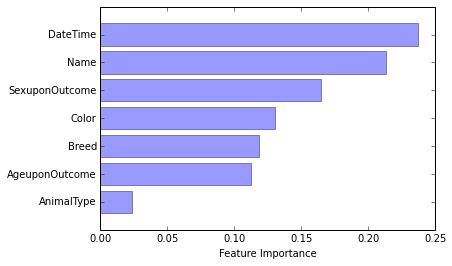

In [454]:
# plot feature importance
plot_feature_importance(model.best_estimator_.feature_importances_, dict_cols['categorical_cols'] + dict_cols['numerical_cols'])

## Merge breed

In [685]:
dict_cols, full_data = load_data()

Loading train data finished in 0.067s
Loading test data finished in 0.090s
train data size: 26729
test data size: 11456


In [686]:
full_data['AgeuponOutcome'] = full_data['AgeuponOutcome'].apply(age2days)
full_data['Breed'] = full_data['Breed'].apply(lambda x: '-'.join(sorted(list(set(x.split("/"))))))
dict_cols['categorical_cols'].remove('AgeuponOutcome')
dict_cols['numerical_cols'].append('AgeuponOutcome')

In [687]:
label_encoding(dict_cols['categorical_cols'] + dict_cols['label_col'], full_data)

Label encoding column: Name
Label encoding column: AnimalType
Label encoding column: SexuponOutcome
Label encoding column: Breed
Label encoding column: Color
Label encoding column: DateTime
Label encoding column: OutcomeType


{nan: 0,
 'Adoption': 1,
 'Died': 2,
 'Euthanasia': 3,
 'Return_to_owner': 4,
 'Transfer': 5}

In [688]:
train_X = full_data[:dict_cols['train_size']][dict_cols['categorical_cols'] + dict_cols['numerical_cols']].values
train_y = full_data[:dict_cols['train_size']][dict_cols['label_col']].values.reshape(dict_cols['train_size'])
param_grid = {'criterion':['gini', 'entropy'], 'n_estimators':[500], 'random_state' : [1234]}
model = search_model(train_X
            , train_y
            , RandomForestClassifier()
            , param_grid
            , -1
            , 4
            , True)

Fitting 4 folds for each of 2 candidates, totalling 8 fits
[CV] n_estimators=500, random_state=1234, criterion=gini .............
[CV] n_estimators=500, random_state=1234, criterion=gini .............
[CV] n_estimators=500, random_state=1234, criterion=gini .............
[CV] n_estimators=500, random_state=1234, criterion=gini .............
[CV] n_estimators=500, random_state=1234, criterion=entropy ..........
[CV] n_estimators=500, random_state=1234, criterion=entropy ..........
[CV] n_estimators=500, random_state=1234, criterion=entropy ..........
[CV] n_estimators=500, random_state=1234, criterion=entropy ..........
[CV]  n_estimators=500, random_state=1234, criterion=gini, score=-1.059662 -  22.2s
[CV]  n_estimators=500, random_state=1234, criterion=gini, score=-1.033389 -  22.2s


[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   22.3s remaining:   -2.5s


[CV]  n_estimators=500, random_state=1234, criterion=gini, score=-1.027854 -  22.5s
[CV]  n_estimators=500, random_state=1234, criterion=gini, score=-1.027221 -  22.6s


[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   22.5s remaining:   -2.5s
[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   22.6s remaining:   -2.5s


[CV]  n_estimators=500, random_state=1234, criterion=entropy, score=-1.066090 -  32.7s
[CV]  n_estimators=500, random_state=1234, criterion=entropy, score=-1.011566 -  32.9s


[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   32.8s remaining:   -3.6s


[CV]  n_estimators=500, random_state=1234, criterion=entropy, score=-1.049797 -  33.1s


[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   33.0s remaining:   -3.7s
[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   33.2s remaining:   -3.7s


[CV]  n_estimators=500, random_state=1234, criterion=entropy, score=-1.036608 -  33.3s


[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   33.4s remaining:   -3.7s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   33.4s finished


Best score: -1.037
('Best parameters set:', {'n_estimators': 500, 'random_state': 1234, 'criterion': 'gini'})
('Scores:', [mean: -1.03703, std: 0.01328, params: {'n_estimators': 500, 'random_state': 1234, 'criterion': 'gini'}, mean: -1.04102, std: 0.01995, params: {'n_estimators': 500, 'random_state': 1234, 'criterion': 'entropy'}])


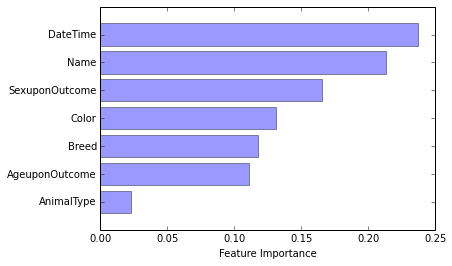

In [689]:
plot_feature_importance(model.best_estimator_.feature_importances_, dict_cols['categorical_cols'] + dict_cols['numerical_cols'])

## Add name length

In [7]:
dict_cols, full_data = load_data()

Loading train data finished in 0.073s
Loading test data finished in 0.096s
train data size: 26729
test data size: 11456


In [8]:
full_data['AgeuponOutcome'] = full_data['AgeuponOutcome'].apply(age2days)
full_data['Breed'] = full_data['Breed'].apply(lambda x: '-'.join(sorted(list(set(x.split("/"))))))

In [10]:
full_data['NameLength'] = full_data['Name'].apply(lambda x: len(str(x)) if x else 0)

In [11]:
dict_cols['categorical_cols'].remove('AgeuponOutcome')
dict_cols['numerical_cols'].append('AgeuponOutcome')
dict_cols['numerical_cols'].append('NameLength')

In [12]:
label_encoding(dict_cols['categorical_cols'] + dict_cols['label_col'], full_data)

Label encoding column: Name
Label encoding column: AnimalType
Label encoding column: SexuponOutcome
Label encoding column: Breed
Label encoding column: Color
Label encoding column: DateTime
Label encoding column: OutcomeType


{nan: 0,
 'Adoption': 1,
 'Died': 2,
 'Euthanasia': 3,
 'Return_to_owner': 4,
 'Transfer': 5}

In [13]:
train_X = full_data[:dict_cols['train_size']][dict_cols['categorical_cols'] + dict_cols['numerical_cols']].values
train_y = full_data[:dict_cols['train_size']][dict_cols['label_col']].values.reshape(dict_cols['train_size'])
param_grid = {'criterion':['gini', 'entropy'], 'n_estimators':[500], 'random_state' : [1234]}
model = search_model(train_X
            , train_y
            , RandomForestClassifier()
            , param_grid
            , -1
            , 4
            , True)

Fitting 4 folds for each of 2 candidates, totalling 8 fits
[CV] n_estimators=500, random_state=1234, criterion=gini .............
[CV] n_estimators=500, random_state=1234, criterion=gini .............
[CV] n_estimators=500, random_state=1234, criterion=gini .............
[CV] n_estimators=500, random_state=1234, criterion=gini .............
[CV] n_estimators=500, random_state=1234, criterion=entropy ..........
[CV] n_estimators=500, random_state=1234, criterion=entropy ..........
[CV] n_estimators=500, random_state=1234, criterion=entropy ..........
[CV] n_estimators=500, random_state=1234, criterion=entropy ..........
[CV]  n_estimators=500, random_state=1234, criterion=gini, score=-1.003362 -  23.0s
[CV]  n_estimators=500, random_state=1234, criterion=gini, score=-1.010711 -  23.0s
[CV]  n_estimators=500, random_state=1234, criterion=gini, score=-1.022240 -  23.2s
[CV]  n_estimators=500, random_state=1234, criterion=gini, score=-0.997411 -  23.2s


[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   23.1s remaining:   -2.6s
[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   23.2s remaining:   -2.6s
[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   23.3s remaining:   -2.6s


[CV]  n_estimators=500, random_state=1234, criterion=entropy, score=-1.023559 -  31.7s
[CV]  n_estimators=500, random_state=1234, criterion=entropy, score=-0.997975 -  31.7s
[CV]  n_estimators=500, random_state=1234, criterion=entropy, score=-1.030174 -  31.9s


[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   31.8s remaining:   -3.5s
[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   31.9s remaining:   -3.5s
[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   32.0s remaining:   -3.6s


[CV]  n_estimators=500, random_state=1234, criterion=entropy, score=-1.003595 -  31.9s


[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   32.0s remaining:   -3.6s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   32.0s finished


Best score: -1.008
('Best parameters set:', {'n_estimators': 500, 'random_state': 1234, 'criterion': 'gini'})
('Scores:', [mean: -1.00843, std: 0.00926, params: {'n_estimators': 500, 'random_state': 1234, 'criterion': 'gini'}, mean: -1.01383, std: 0.01340, params: {'n_estimators': 500, 'random_state': 1234, 'criterion': 'entropy'}])


In [ ]:
plot_feature_importance(model.best_estimator_.feature_importances_, dict_cols['categorical_cols'] + dict_cols['numerical_cols'])

## Name gender

In [491]:
dict_cols, full_data = load_data()

Loading train data finished in 0.066s
Loading test data finished in 0.091s
train data size: 26729
test data size: 11456


In [492]:
full_data['AgeuponOutcome'] = full_data['AgeuponOutcome'].apply(age2days)
full_data['Breed'] = full_data['Breed'].apply(lambda x: '-'.join(sorted(list(set(x.split("/"))))))
full_data['NameLength'] = full_data['Name'].apply(lambda x: len(str(x)) if x==x else 0)

In [493]:
dict_cols['categorical_cols'].remove('AgeuponOutcome')
dict_cols['numerical_cols'].append('AgeuponOutcome')
dict_cols['numerical_cols'].append('NameLength')

In [494]:
# transform sexuponoutcome into female, male, none
import re
full_data['SexuponOutcome'] = full_data['SexuponOutcome'].apply(lambda x : ''.join(re.findall(r'Male|Female', str(x))).lower() if x==x else '')

# obtain gender from name
namegender = pd.read_csv('./data/namegender.csv').set_index('name')
namegender['gender'].replace('none', '', inplace=True)

def get_gender(x):
    if x in list(namegender.index):
        return ''.join(namegender.loc[x]['gender'])
    else:
        return ''
    
full_data['namegender'] = full_data['Name'].apply(lambda x : get_gender(x) if x==x else '')
dict_cols['categorical_cols'].append('namegender')
# add new feature of if name gender is equal to sex
full_data['sex_gender'] = full_data.apply(lambda x : x['SexuponOutcome'] == x['namegender'], axis=1)
dict_cols['categorical_cols'].append('sex_gender')

In [517]:
label_encoding(dict_cols['categorical_cols'] + dict_cols['label_col'], full_data)

Label encoding column: Name
Label encoding column: AnimalType
Label encoding column: SexuponOutcome
Label encoding column: Breed
Label encoding column: Color
Label encoding column: DateTime
Label encoding column: namegender
Label encoding column: sex_gender
Label encoding column: OutcomeType


{nan: 0,
 'Adoption': 1,
 'Died': 2,
 'Euthanasia': 3,
 'Return_to_owner': 4,
 'Transfer': 5}

In [518]:
train_X = full_data[:dict_cols['train_size']][dict_cols['categorical_cols'] + dict_cols['numerical_cols']].values
train_y = full_data[:dict_cols['train_size']][dict_cols['label_col']].values.reshape(dict_cols['train_size'])
param_grid = {'criterion':['gini', 'entropy'], 'n_estimators':[500], 'random_state' : [1234]}
model = search_model(train_X
            , train_y
            , RandomForestClassifier()
            , param_grid
            , -1
            , 4
            , True)

Fitting 4 folds for each of 2 candidates, totalling 8 fits
[CV] n_estimators=500, random_state=1234, criterion=gini .............
[CV] n_estimators=500, random_state=1234, criterion=gini .............
[CV] n_estimators=500, random_state=1234, criterion=gini .............
[CV] n_estimators=500, random_state=1234, criterion=gini .............
[CV] n_estimators=500, random_state=1234, criterion=entropy ..........
[CV] n_estimators=500, random_state=1234, criterion=entropy ..........
[CV] n_estimators=500, random_state=1234, criterion=entropy ..........
[CV] n_estimators=500, random_state=1234, criterion=entropy ..........
[CV]  n_estimators=500, random_state=1234, criterion=gini, score=-1.204250 -  27.6s
[CV]  n_estimators=500, random_state=1234, criterion=gini, score=-1.195812 -  27.6s
[CV]  n_estimators=500, random_state=1234, criterion=gini, score=-1.186180 -  27.6s
[CV]  n_estimators=500, random_state=1234, criterion=gini, score=-1.243609 -  27.6s


[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   27.6s remaining:   -3.1s
[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   27.7s remaining:   -3.1s
[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   27.7s remaining:   -3.1s


[CV]  n_estimators=500, random_state=1234, criterion=entropy, score=-1.228404 -  39.3s
[CV]  n_estimators=500, random_state=1234, criterion=entropy, score=-1.232011 -  39.4s


[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   39.3s remaining:   -4.4s


[CV]  n_estimators=500, random_state=1234, criterion=entropy, score=-1.208315 -  39.5s
[CV]  n_estimators=500, random_state=1234, criterion=entropy, score=-1.213883 -  39.5s


[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   39.5s remaining:   -4.4s
[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   39.6s remaining:   -4.4s
[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   39.6s remaining:   -4.4s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   39.6s finished


Best score: -1.207
('Best parameters set:', {'n_estimators': 500, 'random_state': 1234, 'criterion': 'gini'})
('Scores:', [mean: -1.20746, std: 0.02183, params: {'n_estimators': 500, 'random_state': 1234, 'criterion': 'gini'}, mean: -1.22065, std: 0.00984, params: {'n_estimators': 500, 'random_state': 1234, 'criterion': 'entropy'}])


In [259]:
#genders = Genderize().get(full_data['Name'].tolist()[1:5])

In [636]:
# function to find name gender
# generize only allow maximum 10 request one time
def getGenders(names):        
    names_len = names.size
    req_n = names_len / 10
    max_req = 10
    genders = []
    for i in xrange(req_n + 1):
        url = ''
        cnt = 0
        step = max_req if (i + 1) * max_req >= names_len else names_len % 10
        bf = names[i * max_req : i * max_req + step + 1]
        for j in xrange(bf.size):
            if url == '':
                url = "name[0]=" + bf[j]
            else:
                cnt += 1
                url = "{0}&name[{1}]={2}".format(url, cnt, bf[j])
        print url
        break
    
        req = requests.get("http://api.genderize.io?" + url)
        results = json.loads(req.text)
        genders.append(results)
        break
#         if names.size == 1:
#             results = [results, ]

#         for result in results:
#             if result['gender']:
#                 genders.append((result['name'], result['gender'], result['probability'], result['count']))
#             else:
#                 genders.append((result['name'], u'None',u'0.0',0.0))
    return genders

In [637]:
genders = getGenders(full_data['Name'].unique())

name[0]=Hambone&name[1]=Emily&name[2]=Pearce&name[3]=nan&name[4]=Elsa&name[5]=Jimmy&name[6]=Lucy&name[7]=Rocket&name[8]=Scooter&name[9]=Preston


In [635]:
genders[0:10]

[{u'error': u'Request limit reached'}]

## Datetime

In [519]:
dict_cols, full_data = load_data()

Loading train data finished in 0.073s
Loading test data finished in 0.098s
train data size: 26729
test data size: 11456


In [520]:
full_data['AgeuponOutcome'] = full_data['AgeuponOutcome'].apply(age2days)
full_data['Breed'] = full_data['Breed'].apply(lambda x: '-'.join(sorted(list(set(x.split("/"))))))
full_data['NameLength'] = full_data['Name'].apply(lambda x: len(str(x)) if x else 0)

In [521]:
dict_cols['categorical_cols'].remove('AgeuponOutcome')
dict_cols['numerical_cols'].append('AgeuponOutcome')
dict_cols['numerical_cols'].append('NameLength')

In [522]:
full_data['year'] = full_data['DateTime'].dt.year
full_data['month'] = full_data['DateTime'].dt.month
full_data['day'] = full_data['DateTime'].dt.day
full_data['weekday'] = full_data['DateTime'].dt.dayofweek
full_data['weekyear'] = full_data['DateTime'].dt.weekofyear
full_data['hour'] = full_data['DateTime'].dt.hour

In [523]:
dict_cols['numerical_cols'].append('year')
dict_cols['numerical_cols'].append('month')
dict_cols['numerical_cols'].append('day')
dict_cols['numerical_cols'].append('weekday')
dict_cols['numerical_cols'].append('weekyear')
dict_cols['numerical_cols'].append('hour') 

In [524]:
full_data["DateTime"] = full_data["DateTime"].apply(lambda x:str(x))

In [525]:
# # transform sexuponoutcome into female, male, none
# import re
# full_data['SexuponOutcome'] = full_data['SexuponOutcome'].apply(lambda x : ''.join(re.findall(r'Male|Female', str(x))).lower() if x==x else '')
# # obtain gender from name
# namegender = pd.read_csv('./data/namegender.csv').set_index('name')
# namegender['gender'].replace('none', '', inplace=True)
# def get_gender(x):
#     if x in list(namegender.index):
#         return ''.join(namegender.loc[x]['gender'])
#     else:
#         return ''
# full_data['namegender'] = full_data['Name'].apply(lambda x : get_gender(x) if x==x else '')
# dict_cols['categorical_cols'].append('namegender')
# # add new feature of if name gender is equal to sex
# full_data['sex_gender'] = full_data.apply(lambda x : x['SexuponOutcome'] == x['namegender'], axis=1)
# dict_cols['categorical_cols'].append('sex_gender')

In [526]:
label_encoding(dict_cols['categorical_cols'] + dict_cols['label_col'], full_data)

Label encoding column: Name
Label encoding column: AnimalType
Label encoding column: SexuponOutcome
Label encoding column: Breed
Label encoding column: Color
Label encoding column: DateTime
Label encoding column: namegender
Label encoding column: sex_gender
Label encoding column: OutcomeType


{nan: 0,
 'Adoption': 1,
 'Died': 2,
 'Euthanasia': 3,
 'Return_to_owner': 4,
 'Transfer': 5}

In [527]:
train_X = full_data[:dict_cols['train_size']][dict_cols['categorical_cols'] + dict_cols['numerical_cols']].values
train_y = full_data[:dict_cols['train_size']][dict_cols['label_col']].values.reshape(dict_cols['train_size'])
param_grid = {'criterion':['gini', 'entropy'], 'n_estimators':[500], 'random_state' : [1234]}
model = search_model(train_X
            , train_y
            , RandomForestClassifier()
            , param_grid
            , -1
            , 4
            , True)

Fitting 4 folds for each of 2 candidates, totalling 8 fits
[CV] n_estimators=500, random_state=1234, criterion=gini .............
[CV] n_estimators=500, random_state=1234, criterion=gini .............
[CV] n_estimators=500, random_state=1234, criterion=gini .............
[CV] n_estimators=500, random_state=1234, criterion=gini .............
[CV] n_estimators=500, random_state=1234, criterion=entropy ..........
[CV] n_estimators=500, random_state=1234, criterion=entropy ..........
[CV] n_estimators=500, random_state=1234, criterion=entropy ..........
[CV] n_estimators=500, random_state=1234, criterion=entropy ..........
[CV]  n_estimators=500, random_state=1234, criterion=gini, score=-0.911523 -  30.0s
[CV]  n_estimators=500, random_state=1234, criterion=gini, score=-0.887272 -  30.0s
[CV]  n_estimators=500, random_state=1234, criterion=gini, score=-0.909321 -  30.0s
[CV]  n_estimators=500, random_state=1234, criterion=gini, score=-0.885906 -  30.0s


[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   30.0s remaining:   -3.3s
[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   30.1s remaining:   -3.3s
[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   30.1s remaining:   -3.3s


[CV]  n_estimators=500, random_state=1234, criterion=entropy, score=-0.893414 -  40.9s
[CV]  n_estimators=500, random_state=1234, criterion=entropy, score=-0.904375 -  41.0s
[CV]  n_estimators=500, random_state=1234, criterion=entropy, score=-0.922422 -  41.1s
[CV]  n_estimators=500, random_state=1234, criterion=entropy, score=-0.906418 -  41.0s


[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   41.0s remaining:   -4.6s
[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   41.1s remaining:   -4.6s
[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   41.2s remaining:   -4.6s
[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   41.2s remaining:   -4.6s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   41.2s finished


Best score: -0.899
('Best parameters set:', {'n_estimators': 500, 'random_state': 1234, 'criterion': 'gini'})
('Scores:', [mean: -0.89850, std: 0.01195, params: {'n_estimators': 500, 'random_state': 1234, 'criterion': 'gini'}, mean: -0.90666, std: 0.01036, params: {'n_estimators': 500, 'random_state': 1234, 'criterion': 'entropy'}])


In [528]:
preds = model.best_estimator_.predict(full_data[dict_cols['train_size']:][dict_cols['categorical_cols'] + dict_cols['numerical_cols']])

## Add age noise

In [586]:
dict_cols, full_data = load_data()
full_data['AgeuponOutcome'] = full_data['AgeuponOutcome'].apply(age2days)
full_data['Breed'] = full_data['Breed'].apply(lambda x: '-'.join(sorted(list(set(x.split("/"))))))
full_data['NameLength'] = full_data['Name'].apply(lambda x: len(str(x)) if x else 0)

Loading train data finished in 0.065s
Loading test data finished in 0.087s
train data size: 26729
test data size: 11456


In [587]:
dict_cols['categorical_cols'].remove('AgeuponOutcome')
dict_cols['numerical_cols'].append('AgeuponOutcome')
dict_cols['numerical_cols'].append('NameLength')

In [588]:
full_data['year'] = full_data['DateTime'].dt.year
full_data['month'] = full_data['DateTime'].dt.month
full_data['day'] = full_data['DateTime'].dt.day
full_data['weekday'] = full_data['DateTime'].dt.dayofweek
full_data['weekyear'] = full_data['DateTime'].dt.weekofyear
full_data['hour'] = full_data['DateTime'].dt.hour

In [589]:
dict_cols['numerical_cols'].append('year')
dict_cols['numerical_cols'].append('month')
dict_cols['numerical_cols'].append('day')
dict_cols['numerical_cols'].append('weekday')
dict_cols['numerical_cols'].append('weekyear')
dict_cols['numerical_cols'].append('hour') 

In [590]:
# add one random day between 0 to 100
full_data['AgeuponOutcome'] = full_data['AgeuponOutcome'].apply(lambda x : x + random.randrange(0, 101, 1))

In [591]:
label_encoding(dict_cols['categorical_cols'] + dict_cols['label_col'], full_data)

Label encoding column: Name
Label encoding column: AnimalType
Label encoding column: SexuponOutcome
Label encoding column: Breed
Label encoding column: Color
Label encoding column: DateTime
Label encoding column: OutcomeType


{nan: 0,
 'Adoption': 1,
 'Died': 2,
 'Euthanasia': 3,
 'Return_to_owner': 4,
 'Transfer': 5}

In [592]:
train_X = full_data[:dict_cols['train_size']][dict_cols['categorical_cols'] + dict_cols['numerical_cols']].values
train_y = full_data[:dict_cols['train_size']][dict_cols['label_col']].values.reshape(dict_cols['train_size'])
param_grid = {'criterion':['gini', 'entropy'], 'n_estimators':[500], 'random_state' : [1234]}
model = search_model(train_X
            , train_y
            , RandomForestClassifier()
            , param_grid
            , -1
            , 4
            , True)

Fitting 4 folds for each of 2 candidates, totalling 8 fits
[CV] n_estimators=500, random_state=1234, criterion=gini .............
[CV] n_estimators=500, random_state=1234, criterion=gini .............
[CV] n_estimators=500, random_state=1234, criterion=gini .............
[CV] n_estimators=500, random_state=1234, criterion=gini .............
[CV] n_estimators=500, random_state=1234, criterion=entropy ..........
[CV] n_estimators=500, random_state=1234, criterion=entropy ..........
[CV] n_estimators=500, random_state=1234, criterion=entropy ..........
[CV] n_estimators=500, random_state=1234, criterion=entropy ..........
[CV]  n_estimators=500, random_state=1234, criterion=gini, score=-0.808125 -  25.4s
[CV]  n_estimators=500, random_state=1234, criterion=gini, score=-0.790781 -  25.4s
[CV]  n_estimators=500, random_state=1234, criterion=gini, score=-0.785853 -  25.4s
[CV]  n_estimators=500, random_state=1234, criterion=gini, score=-0.796423 -  25.5s


[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   25.5s remaining:   -2.8s
[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   25.5s remaining:   -2.8s
[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   25.6s remaining:   -2.8s


[CV]  n_estimators=500, random_state=1234, criterion=entropy, score=-0.807148 -  34.6s
[CV]  n_estimators=500, random_state=1234, criterion=entropy, score=-0.802316 -  34.7s
[CV]  n_estimators=500, random_state=1234, criterion=entropy, score=-0.794996 -  34.7s


[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   34.6s remaining:   -3.8s
[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   34.8s remaining:   -3.9s
[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   34.8s remaining:   -3.9s


[CV]  n_estimators=500, random_state=1234, criterion=entropy, score=-0.803245 -  34.8s


[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   34.9s remaining:   -3.9s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   34.9s finished


Best score: -0.795
('Best parameters set:', {'n_estimators': 500, 'random_state': 1234, 'criterion': 'gini'})
('Scores:', [mean: -0.79530, std: 0.00830, params: {'n_estimators': 500, 'random_state': 1234, 'criterion': 'gini'}, mean: -0.80193, std: 0.00439, params: {'n_estimators': 500, 'random_state': 1234, 'criterion': 'entropy'}])


In [593]:
preds = model.best_estimator_.predict(full_data[dict_cols['train_size']:][dict_cols['categorical_cols'] + dict_cols['numerical_cols']])

## add hodidays

In [605]:
dict_cols, full_data = load_data()
full_data['AgeuponOutcome'] = full_data['AgeuponOutcome'].apply(age2days)
full_data['Breed'] = full_data['Breed'].apply(lambda x: '-'.join(sorted(list(set(x.split("/"))))))
full_data['NameLength'] = full_data['Name'].apply(lambda x: len(str(x)) if x else 0)

Loading train data finished in 0.064s
Loading test data finished in 0.085s
train data size: 26729
test data size: 11456


In [606]:
dict_cols['categorical_cols'].remove('AgeuponOutcome')
dict_cols['numerical_cols'].append('AgeuponOutcome')
dict_cols['numerical_cols'].append('NameLength')

In [607]:
full_data['year'] = full_data['DateTime'].dt.year
full_data['month'] = full_data['DateTime'].dt.month
full_data['day'] = full_data['DateTime'].dt.day
full_data['weekday'] = full_data['DateTime'].dt.dayofweek
full_data['weekyear'] = full_data['DateTime'].dt.weekofyear
full_data['hour'] = full_data['DateTime'].dt.hour

In [608]:
dict_cols['numerical_cols'].append('year')
dict_cols['numerical_cols'].append('month')
dict_cols['numerical_cols'].append('day')
dict_cols['numerical_cols'].append('weekday')
dict_cols['numerical_cols'].append('weekyear')
dict_cols['numerical_cols'].append('hour') 

In [617]:
# add holidays
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
# add holidays
cal = calendar()
holidays = cal.holidays(start=full_data['DateTime'].min(), end=full_data['DateTime'].max())
full_data['isholiday'] = dr.isin(holidays)
dict_cols['categorical_cols'].append('isholiday')

In [620]:
label_encoding(dict_cols['categorical_cols'] + dict_cols['label_col'], full_data)

Label encoding column: Name
Label encoding column: AnimalType
Label encoding column: SexuponOutcome
Label encoding column: Breed
Label encoding column: Color
Label encoding column: DateTime
Label encoding column: isholiday
Label encoding column: OutcomeType


{nan: 0,
 'Adoption': 1,
 'Died': 2,
 'Euthanasia': 3,
 'Return_to_owner': 4,
 'Transfer': 5}

In [622]:
train_X = full_data[:dict_cols['train_size']][dict_cols['categorical_cols'] + dict_cols['numerical_cols']].values
train_y = full_data[:dict_cols['train_size']][dict_cols['label_col']].values.reshape(dict_cols['train_size'])
param_grid = {'criterion':['gini', 'entropy'], 'n_estimators':[500], 'random_state' : [1234]}
model = search_model(train_X
            , train_y
            , RandomForestClassifier()
            , param_grid
            , -1
            , 4
            , True)

Fitting 4 folds for each of 2 candidates, totalling 8 fits
[CV] n_estimators=500, random_state=1234, criterion=gini .............
[CV] n_estimators=500, random_state=1234, criterion=gini .............
[CV] n_estimators=500, random_state=1234, criterion=gini .............
[CV] n_estimators=500, random_state=1234, criterion=gini .............
[CV] n_estimators=500, random_state=1234, criterion=entropy ..........
[CV] n_estimators=500, random_state=1234, criterion=entropy ..........
[CV] n_estimators=500, random_state=1234, criterion=entropy ..........
[CV] n_estimators=500, random_state=1234, criterion=entropy ..........
[CV]  n_estimators=500, random_state=1234, criterion=gini, score=-0.794601 -  24.9s
[CV]  n_estimators=500, random_state=1234, criterion=gini, score=-0.802767 -  25.1s
[CV]  n_estimators=500, random_state=1234, criterion=gini, score=-0.816322 -  25.1s
[CV]  n_estimators=500, random_state=1234, criterion=gini, score=-0.794220 -  25.2s


[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   25.1s remaining:   -2.8s
[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   25.2s remaining:   -2.8s
[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   25.3s remaining:   -2.8s


[CV]  n_estimators=500, random_state=1234, criterion=entropy, score=-0.798967 -  33.0s
[CV]  n_estimators=500, random_state=1234, criterion=entropy, score=-0.788518 -  33.0s
[CV]  n_estimators=500, random_state=1234, criterion=entropy, score=-0.816734 -  33.1s
[CV]  n_estimators=500, random_state=1234, criterion=entropy, score=-0.824836 -  33.1s


[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   33.1s remaining:   -3.7s
[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   33.2s remaining:   -3.7s
[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   33.2s remaining:   -3.7s
[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   33.3s remaining:   -3.7s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   33.3s finished


Best score: -0.802
('Best parameters set:', {'n_estimators': 500, 'random_state': 1234, 'criterion': 'gini'})
('Scores:', [mean: -0.80198, std: 0.00896, params: {'n_estimators': 500, 'random_state': 1234, 'criterion': 'gini'}, mean: -0.80726, std: 0.01431, params: {'n_estimators': 500, 'random_state': 1234, 'criterion': 'entropy'}])


In [623]:
preds = model.best_estimator_.predict(full_data[dict_cols['train_size']:][dict_cols['categorical_cols'] + dict_cols['numerical_cols']])

In [ ]:
With age into days, the name length, breed merged, datetime split, the lb score is 10.404
# Get genders by names using https://genderize.io and see if it helps
genders not help with lb 12.00235

# Add noises to age (days) - hint: using random function.
10.45268

# Add holidays and validate the impacts

## add all up

In [626]:
dict_cols, full_data = load_data()
full_data['AgeuponOutcome'] = full_data['AgeuponOutcome'].apply(age2days)
full_data['Breed'] = full_data['Breed'].apply(lambda x: '-'.join(sorted(list(set(x.split("/"))))))
full_data['NameLength'] = full_data['Name'].apply(lambda x: len(str(x)) if x else 0)

Loading train data finished in 0.068s
Loading test data finished in 0.090s
train data size: 26729
test data size: 11456


In [627]:
dict_cols['categorical_cols'].remove('AgeuponOutcome')
dict_cols['numerical_cols'].append('AgeuponOutcome')
dict_cols['numerical_cols'].append('NameLength')

In [628]:
full_data['year'] = full_data['DateTime'].dt.year
full_data['month'] = full_data['DateTime'].dt.month
full_data['day'] = full_data['DateTime'].dt.day
full_data['weekday'] = full_data['DateTime'].dt.dayofweek
full_data['weekyear'] = full_data['DateTime'].dt.weekofyear
full_data['hour'] = full_data['DateTime'].dt.hour

In [629]:
dict_cols['numerical_cols'].append('year')
dict_cols['numerical_cols'].append('month')
dict_cols['numerical_cols'].append('day')
dict_cols['numerical_cols'].append('weekday')
dict_cols['numerical_cols'].append('weekyear')
dict_cols['numerical_cols'].append('hour') 

In [630]:
# add holidays
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
# add holidays
cal = calendar()
holidays = cal.holidays(start=full_data['DateTime'].min(), end=full_data['DateTime'].max())
full_data['isholiday'] = dr.isin(holidays)
dict_cols['categorical_cols'].append('isholiday')

In [631]:
# transform sexuponoutcome into female, male, none
import re
full_data['SexuponOutcome'] = full_data['SexuponOutcome'].apply(lambda x : ''.join(re.findall(r'Male|Female', str(x))).lower() if x==x else '')

# obtain gender from name
namegender = pd.read_csv('./data/namegender.csv').set_index('name')
namegender['gender'].replace('none', '', inplace=True)

def get_gender(x):
    if x in list(namegender.index):
        return ''.join(namegender.loc[x]['gender'])
    else:
        return ''
    
full_data['namegender'] = full_data['Name'].apply(lambda x : get_gender(x) if x==x else '')
dict_cols['categorical_cols'].append('namegender')
# add new feature of if name gender is equal to sex
full_data['sex_gender'] = full_data.apply(lambda x : x['SexuponOutcome'] == x['namegender'], axis=1)
dict_cols['categorical_cols'].append('sex_gender')

In [632]:
# add one random day between 0 to 100
full_data['AgeuponOutcome'] = full_data['AgeuponOutcome'].apply(lambda x : x + random.randrange(0, 101, 1))

In [633]:
label_encoding(dict_cols['categorical_cols'] + dict_cols['label_col'], full_data)

Label encoding column: Name
Label encoding column: AnimalType
Label encoding column: SexuponOutcome
Label encoding column: Breed
Label encoding column: Color
Label encoding column: DateTime
Label encoding column: isholiday
Label encoding column: namegender
Label encoding column: sex_gender
Label encoding column: OutcomeType


{nan: 0,
 'Adoption': 1,
 'Died': 2,
 'Euthanasia': 3,
 'Return_to_owner': 4,
 'Transfer': 5}

In [634]:
train_X = full_data[:dict_cols['train_size']][dict_cols['categorical_cols'] + dict_cols['numerical_cols']].values
train_y = full_data[:dict_cols['train_size']][dict_cols['label_col']].values.reshape(dict_cols['train_size'])
param_grid = {'criterion':['gini', 'entropy'], 'n_estimators':[500], 'random_state' : [1234]}
model = search_model(train_X
            , train_y
            , RandomForestClassifier()
            , param_grid
            , -1
            , 4
            , True)

Fitting 4 folds for each of 2 candidates, totalling 8 fits
[CV] n_estimators=500, random_state=1234, criterion=gini .............
[CV] n_estimators=500, random_state=1234, criterion=gini .............
[CV] n_estimators=500, random_state=1234, criterion=gini .............
[CV] n_estimators=500, random_state=1234, criterion=gini .............
[CV] n_estimators=500, random_state=1234, criterion=entropy ..........
[CV] n_estimators=500, random_state=1234, criterion=entropy ..........
[CV] n_estimators=500, random_state=1234, criterion=entropy ..........
[CV] n_estimators=500, random_state=1234, criterion=entropy ..........
[CV]  n_estimators=500, random_state=1234, criterion=gini, score=-0.899731 -  33.1s
[CV]  n_estimators=500, random_state=1234, criterion=gini, score=-0.910924 -  33.2s
[CV]  n_estimators=500, random_state=1234, criterion=gini, score=-0.903366 -  33.2s
[CV]  n_estimators=500, random_state=1234, criterion=gini, score=-0.897818 -  33.3s


[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   33.3s remaining:   -3.7s
[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   33.3s remaining:   -3.7s
[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   33.4s remaining:   -3.7s


[CV]  n_estimators=500, random_state=1234, criterion=entropy, score=-0.900559 -  44.7s
[CV]  n_estimators=500, random_state=1234, criterion=entropy, score=-0.911982 -  44.8s
[CV]  n_estimators=500, random_state=1234, criterion=entropy, score=-0.874973 -  44.8s


[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   44.8s remaining:   -5.0s
[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   44.9s remaining:   -5.0s
[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   44.9s remaining:   -5.0s


[CV]  n_estimators=500, random_state=1234, criterion=entropy, score=-0.892041 -  44.9s


[Parallel(n_jobs=-1)]: Done   9 out of   8 | elapsed:   45.0s remaining:   -5.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   45.0s finished


Best score: -0.895
('Best parameters set:', {'n_estimators': 500, 'random_state': 1234, 'criterion': 'entropy'})
('Scores:', [mean: -0.90296, std: 0.00501, params: {'n_estimators': 500, 'random_state': 1234, 'criterion': 'gini'}, mean: -0.89489, std: 0.01350, params: {'n_estimators': 500, 'random_state': 1234, 'criterion': 'entropy'}])


In [ ]:
preds = model.best_estimator_.predict(full_data[dict_cols['train_size']:][dict_cols['categorical_cols'] + dict_cols['numerical_cols']])

## write out submission

In [624]:
submission = pd.read_csv('./data/sample_submission.csv')
submission['Adoption'] = 0
#label_mapping
for idx, val in enumerate(preds):
    #print index, value
    if val == 0:
        submission.iloc[idx]['Died'] = 1
    else:
        submission.iloc[idx][val] = 1

In [625]:
path = './data/submission_' + str(datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")) + '.csv'
submission.to_csv(path, index=False)